

---
WGAN with gradient penalty to satisfy Lipschitz constraint.
DCGAN is used as base architecture of the networks.


---



In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.vision import *
from fastai.vision.gan import *
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image

In [0]:
img_size = 64
img_n_channels = 3
batch_size = 128
use_cuda = torch.cuda.is_available()
# Gradient penalty coefficient
plambda = 10

In [0]:
def mount_gdrive():
  root_dir = '/content'

  if (importlib.util.find_spec("google.colab") is not None):
    from google.colab import drive
    drive.mount('/content/gdrive', force_remount=True)
    root_dir = "/content/gdrive/My Drive/"
  
  return root_dir

In [0]:
# Optional, allows saving parameters in gdrive
root_gdrive = mount_gdrive()
models_root = root_gdrive + 'ML/'

In [0]:
realImagesPath = untar_data("http://vis-www.cs.umass.edu/lfw/lfw")
realImagesPath

PosixPath('/root/.fastai/data/lfw')

In [0]:
def get_data(path, bs, size):
    return (GANItemList.from_folder(path, noise_sz=100)
               .split_none()
               .label_from_func(noop)
               .transform(tfms=[[crop_pad(size=size, row_pct=(0,1), col_pct=(0,1))], []], size=size, tfm_y=True)
               .databunch(bs=bs)
               .normalize(stats = [torch.tensor([0.5,0.5,0.5]), torch.tensor([0.5,0.5,0.5])], do_x=False, do_y=True))

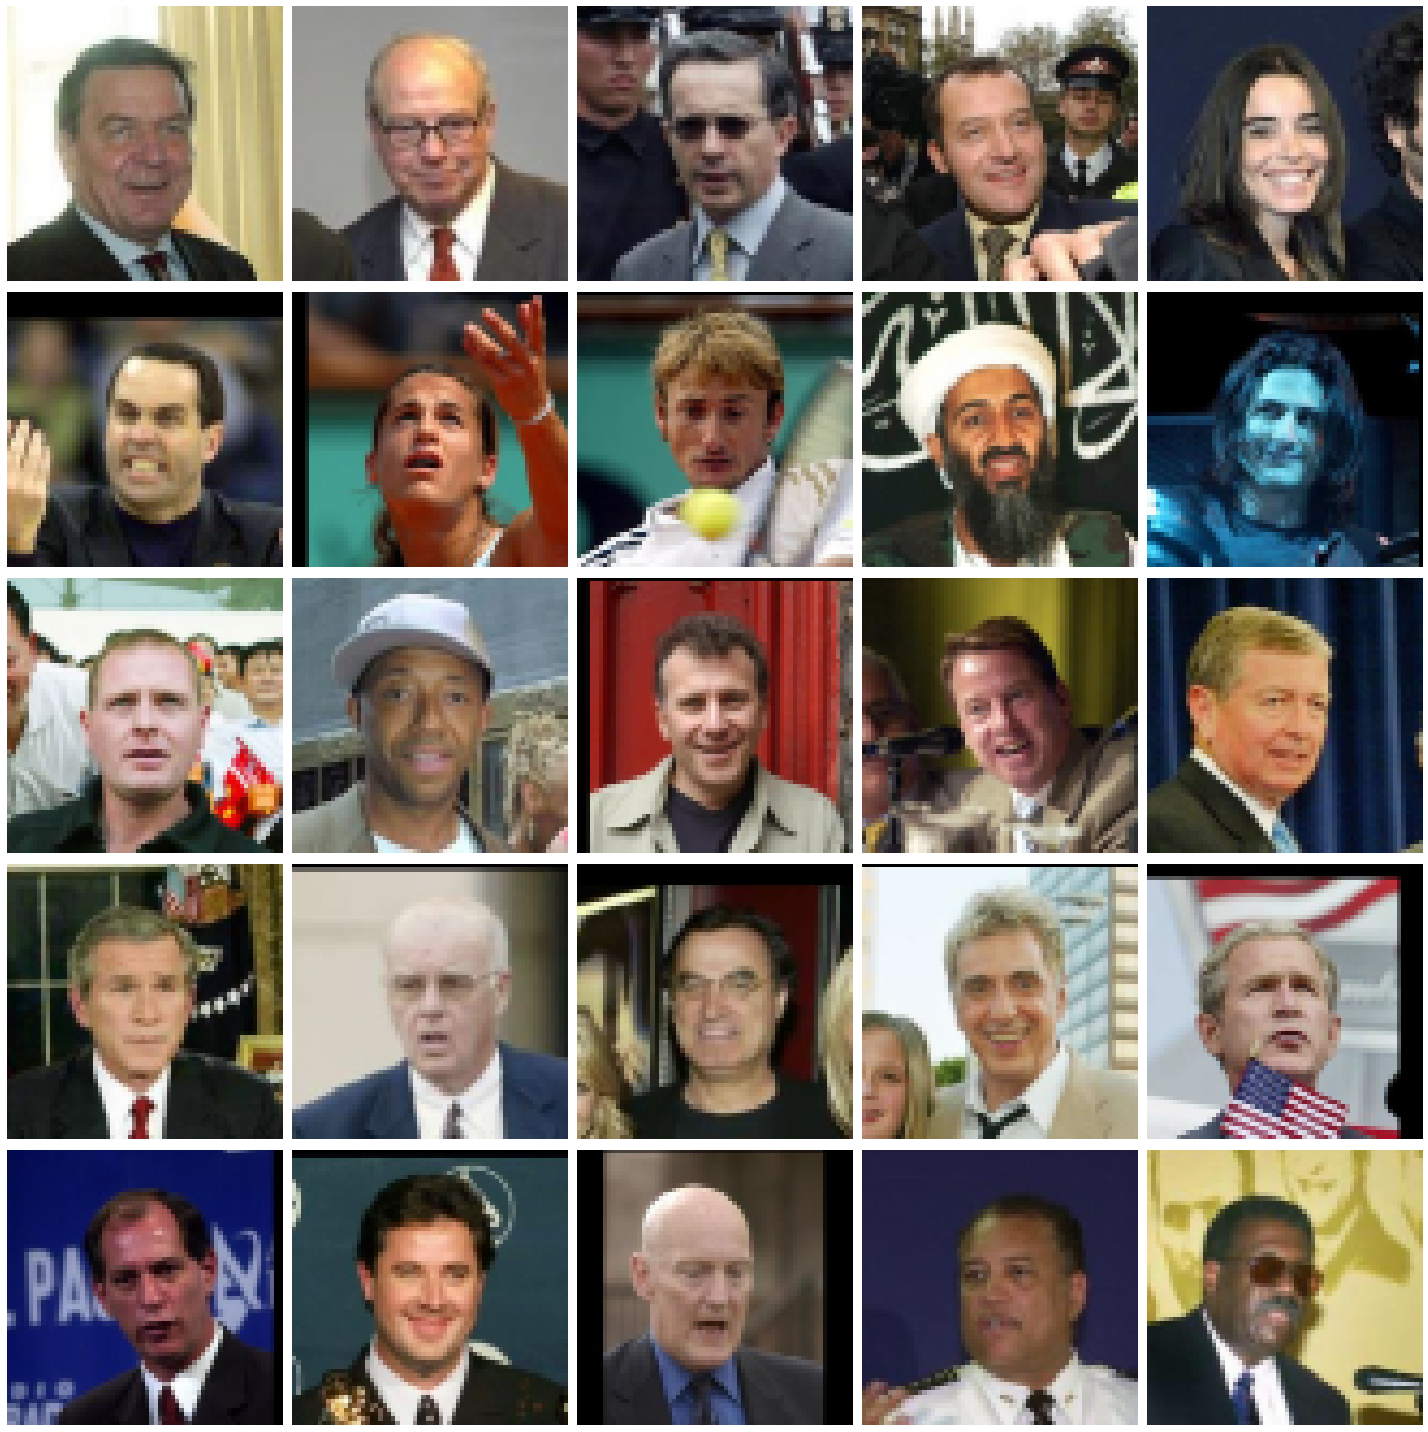

In [0]:
data = get_data(realImagesPath, batch_size, img_size)
data.show_batch()

# CRITIC

In [0]:
critic = basic_critic(img_size, img_n_channels, n_extra_layers=1)

# GENERATOR

In [0]:
generator = basic_generator(img_size, img_n_channels, n_extra_layers=1)

# LEARNER

In [0]:
class GANGPLoss(GANModule):
    "Wrapper around `loss_funcC` (for the critic) and `loss_funcG` (for the generator)."
    def __init__(self, loss_funcG:Callable, loss_funcC:Callable, gan_model:GANModule, real_provider:Callable[[bool], Tensor], plambda:float):
        super().__init__()
        self.loss_funcG,self.loss_funcC,self.gan_model,self.real_provider,self.plambda = loss_funcG,loss_funcC,gan_model,real_provider,plambda

    def generator(self, output, target):
        "Evaluate the `output` with the critic then uses `self.loss_funcG` to combine it with `target`."
        fake_pred = self.gan_model.critic(output)
        return self.loss_funcG(fake_pred, target, output)

    def critic(self, real_pred, input):
        "Create some `fake_pred` with the generator from `input` and compare them to `real_pred` in `self.loss_funcD`."
        real = self.real_provider(self.gen_mode)

        fake = self.gan_model.generator(input.requires_grad_(False)).requires_grad_(True)
        fake_pred = self.gan_model.critic(fake)

        return self.loss_funcC(real_pred, fake_pred) + self._gradient_penalty(real, fake)

    def _gradient_penalty(self, real, fake):
        # A different random value of epsilon for any element of a batch
        epsilon_vec = torch.rand(real.shape[0], 1, 1, 1, dtype=torch.float, device=real.device, requires_grad=False)
        epsilon = epsilon_vec.expand_as(real)
        x_hat = epsilon * real + (1 - epsilon) * fake
        x_hat_pred = critic(x_hat)
        grads = torch.autograd.grad(outputs=x_hat_pred, inputs=x_hat, create_graph=True)[0]

        # Paper says this, but some articles show code samples doing: self.plambda * (grad.norm()**2 - 1)
        return self.plambda * ((grads.norm() - 1)**2)


In [0]:
class CustomGANTrainer(LearnerCallback):
    "Handles GAN Training."
    _order=-20
    def __init__(self, learn:Learner, switch_eval:bool=False, clip:float=None, beta:float=0.98, gen_first:bool=False,
                 show_img:bool=True):
        super().__init__(learn)
        self.switch_eval,self.clip,self.beta,self.gen_first,self.show_img = switch_eval,clip,beta,gen_first,show_img
        self.generator,self.critic = self.model.generator,self.model.critic

    def _set_trainable(self):
        train_model = self.generator if     self.gen_mode else self.critic
        loss_model  = self.generator if not self.gen_mode else self.critic
        requires_grad(train_model, True)
        requires_grad(loss_model, False)
        if self.switch_eval:
            train_model.train()
            loss_model.eval()

    def on_train_begin(self, **kwargs):
        "Create the optimizers for the generator and critic if necessary, initialize smootheners."
        if not getattr(self,'opt_gen',None):
            self.opt_gen = self.opt.new([nn.Sequential(*flatten_model(self.generator))])
        else: self.opt_gen.lr,self.opt_gen.wd = self.opt.lr,self.opt.wd
        if not getattr(self,'opt_critic',None):
            self.opt_critic = self.opt.new([nn.Sequential(*flatten_model(self.critic))])
        else: self.opt_critic.lr,self.opt_critic.wd = self.opt.lr,self.opt.wd
        self.gen_mode = self.gen_first
        self.switch(self.gen_mode)
        self.closses,self.glosses = [],[]
        self.smoothenerG,self.smoothenerC = SmoothenValue(self.beta),SmoothenValue(self.beta)
        #self.recorder.no_val=True
        self.recorder.add_metric_names(['gen_loss', 'disc_loss'])
        self.imgs,self.titles = [],[]

    def on_train_end(self, **kwargs):
        "Switch in generator mode for showing results."
        self.switch(gen_mode=True)

    def on_batch_begin(self, last_input, last_target, **kwargs):
        "Clamp the weights with `self.clip` if it's not None, return the correct input."
        if self.clip is not None:
            for p in self.critic.parameters(): p.data.clamp_(-self.clip, self.clip)
        self.last_real = last_target if not self.gen_mode else None
        if last_input.dtype == torch.float16: last_target = to_half(last_target)
        return {'last_input':last_input,'last_target':last_target} if self.gen_mode else {'last_input':last_target,'last_target':last_input}

    def on_backward_begin(self, last_loss, last_output, **kwargs):
        "Record `last_loss` in the proper list."
        last_loss = last_loss.float().detach().cpu()
        if self.gen_mode:
            self.smoothenerG.add_value(last_loss)
            self.glosses.append(self.smoothenerG.smooth)
            self.last_gen = last_output.detach().cpu()
        else:
            self.smoothenerC.add_value(last_loss)
            self.closses.append(self.smoothenerC.smooth)
    
    def on_batch_end(self, **kwargs):
        self.opt_critic.zero_grad()
        self.opt_gen.zero_grad()
    
    def on_epoch_begin(self, epoch, **kwargs):
        "Put the critic or the generator back to eval if necessary."
        self.switch(self.gen_mode)

    def on_epoch_end(self, pbar, epoch, last_metrics, **kwargs):
        "Put the various losses in the recorder and show a sample image."
        if not hasattr(self, 'last_gen') or not self.show_img: return
        data = self.learn.data
        img = self.last_gen[0]
        norm = getattr(data,'norm',False)
        if norm and norm.keywords.get('do_y',False): img = data.denorm(img)
        img = data.train_ds.y.reconstruct(img)
        self.imgs.append(img)
        self.titles.append(f'Epoch {epoch}')
        pbar.show_imgs(self.imgs, self.titles)
        return add_metrics(last_metrics, [getattr(self.smoothenerG,'smooth',None),getattr(self.smoothenerC,'smooth',None)])

    def switch(self, gen_mode:bool=None):
        "Switch the model, if `gen_mode` is provided, in the desired mode."
        self.gen_mode = (not self.gen_mode) if gen_mode is None else gen_mode
        self.opt.opt = self.opt_gen.opt if self.gen_mode else self.opt_critic.opt
        self._set_trainable()
        self.model.switch(gen_mode)
        self.loss_func.switch(gen_mode)

In [0]:
class GANGPLearner(Learner):
    "A `Learner` suitable for GANs."
    def __init__(self, data:DataBunch, generator:nn.Module, critic:nn.Module, gen_loss_func:LossFunction,
                 crit_loss_func:LossFunction, switcher:Callback=None, gen_first:bool=False, switch_eval:bool=True,
                 show_img:bool=True, clip:float=None, plambda:float=10.0, **learn_kwargs):
        gan = GANModule(generator, critic)
        real_provider = lambda gen_mode: self.gan_trainer.last_real if not gen_mode else None
        loss_func = GANGPLoss(gen_loss_func, crit_loss_func, gan, real_provider, plambda)
        switcher = ifnone(switcher, partial(FixedGANSwitcher, n_crit=5, n_gen=1))
        super().__init__(data, gan, loss_func=loss_func, callback_fns=[switcher], **learn_kwargs)
        trainer = CustomGANTrainer(self, clip=clip, switch_eval=switch_eval, show_img=show_img)
        self.gan_trainer = trainer
        self.callbacks.append(trainer)

    @classmethod
    def from_learners(cls, learn_gen:Learner, learn_crit:Learner, switcher:Callback=None,
                      weights_gen:Tuple[float,float]=None, **learn_kwargs):
        "Create a GAN from `learn_gen` and `learn_crit`."
        losses = gan_loss_from_func(learn_gen.loss_func, learn_crit.loss_func, weights_gen=weights_gen)
        return cls(learn_gen.data, learn_gen.model, learn_crit.model, *losses, switcher=switcher, **learn_kwargs)

    @classmethod
    def wgan(cls, data:DataBunch, generator:nn.Module, critic:nn.Module, switcher:Callback=None, **learn_kwargs):
        "Create a WGAN from `data`, `generator` and `critic`."
        return cls(data, generator, critic, NoopLoss(), WassersteinLoss(), switcher=switcher, **learn_kwargs)

In [0]:
def save_gan_learner(learner, path):
    torch.save({
        'critic': learner.model.critic.state_dict(),
        'generator': learner.model.generator.state_dict()#,
        #'optimizer': learner.opt.get_state()
    }, path)
    
    
def load_gan_learner(learner, path):
    state_dict = torch.load(path)
    learner.model.critic.load_state_dict(state_dict['critic'])
    learner.model.generator.load_state_dict(state_dict['generator'])

# Training

## TR 1: lambda = 10

In [0]:
plambda = 10

### TR 1a: lr=2e-4

In [0]:
lr = 2e-4
learner = GANGPLearner.wgan(data, generator, critic, switch_eval=False, opt_func = partial(optim.Adam, betas = (0.,0.99)), wd=0., plambda=plambda)

epoch,train_loss,valid_loss,gen_loss,disc_loss,time
0,-245.389923,#na#,132.156265,-318.644409,01:06
1,-512.645996,#na#,253.376282,-660.228271,01:06
2,-777.662964,#na#,371.403137,-1001.802063,01:06
3,-1040.311890,#na#,493.142090,-1340.404297,01:06
4,-1122.980835,#na#,608.291626,-1482.897217,01:07
5,-885.649658,#na#,623.112061,-1222.156616,01:06
6,-653.659790,#na#,477.098022,-860.511230,01:06
7,-556.717773,#na#,372.416687,-713.413757,01:06
8,-416.211853,#na#,207.739700,-483.116119,01:07
9,-367.701141,#na#,88.057121,-405.743042,01:06


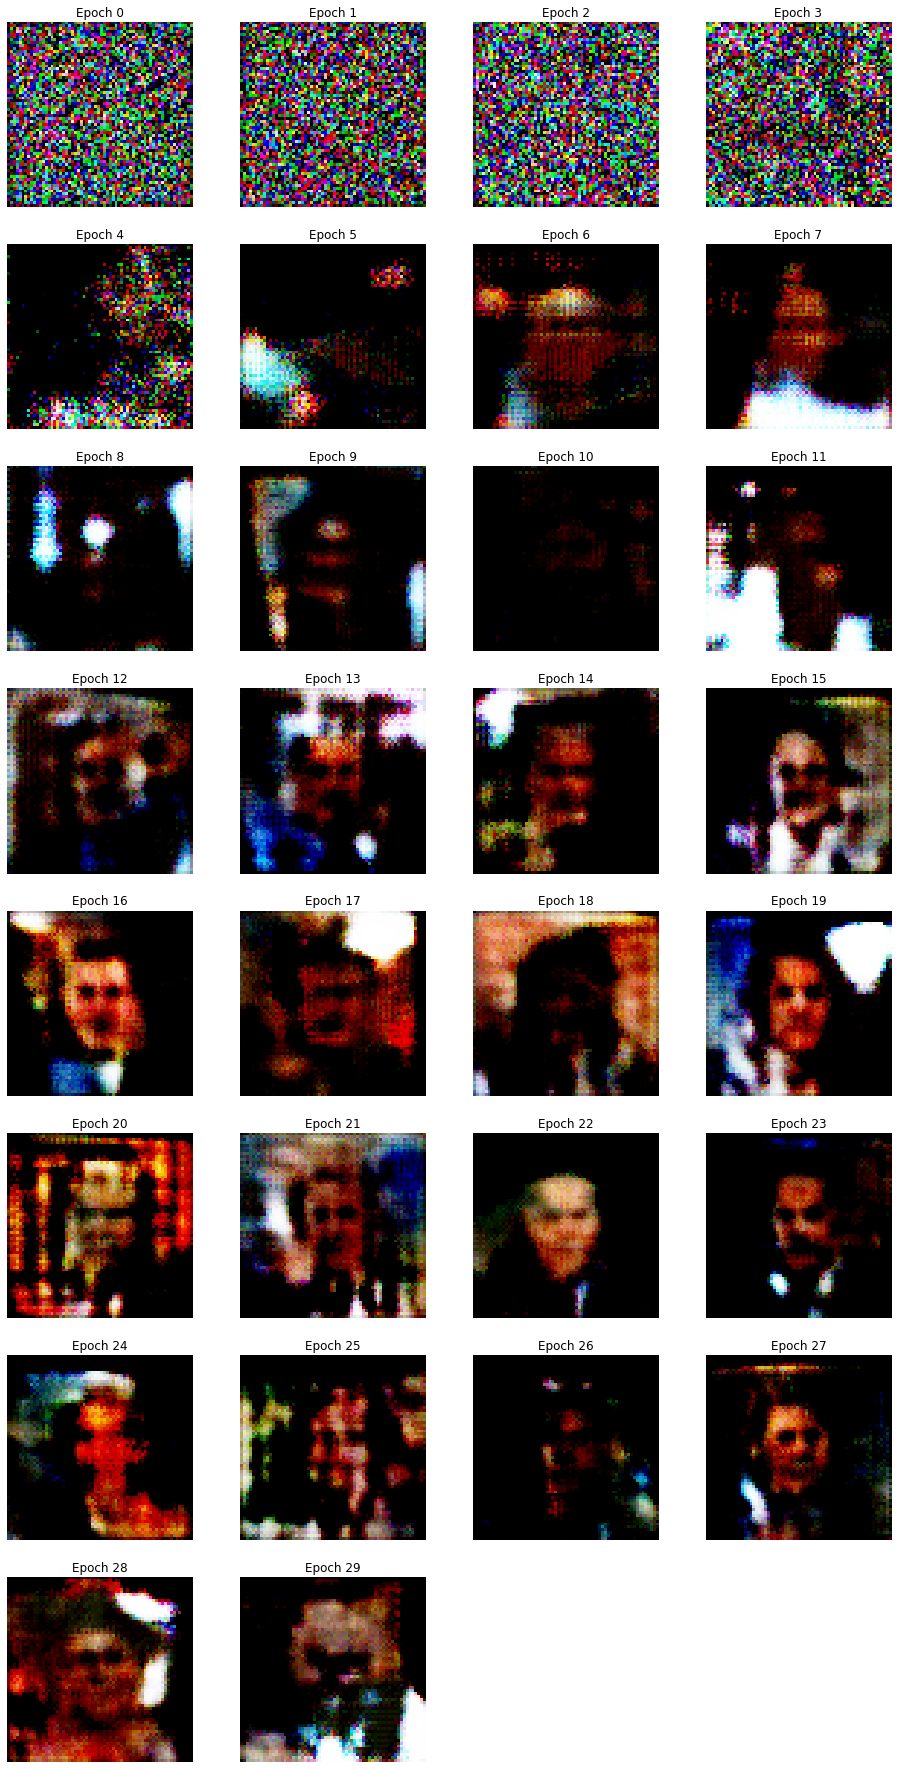

In [0]:
learner.fit(30, lr)
save_gan_learner(learner, models_root + 'wgan-gpTr1a_30it.pth')

epoch,train_loss,valid_loss,gen_loss,disc_loss,time
0,-217.621262,#na#,-348.694672,-190.549240,01:06
1,-226.410446,#na#,-204.547913,-248.135788,01:06
2,-192.767746,#na#,-83.511787,-237.296158,01:06
3,-215.647308,#na#,3.282436,-270.371674,01:06
4,-194.317871,#na#,45.778400,-255.147095,01:07
5,-111.273849,#na#,92.723991,-187.128784,01:06
6,-135.041077,#na#,110.123253,-194.960297,01:06
7,-116.272751,#na#,152.810074,-194.790649,01:06
8,-143.147766,#na#,169.768997,-215.918701,01:06
9,-87.208664,#na#,178.660477,-142.896194,01:06


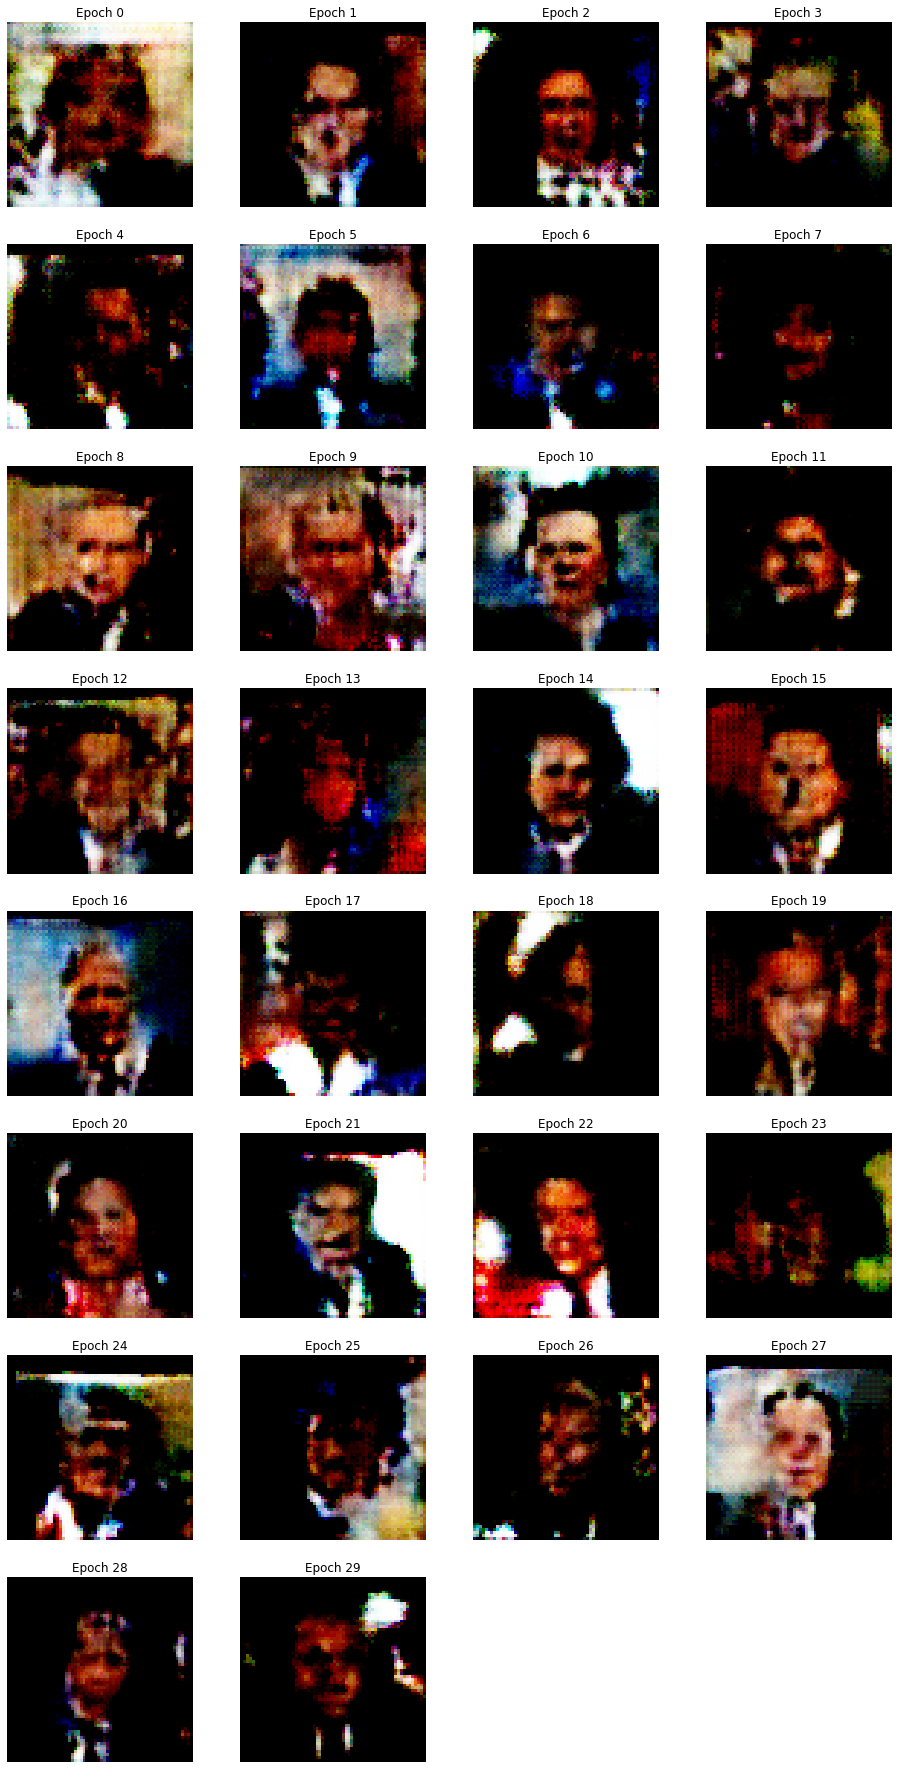

In [0]:
learner.fit(30, lr)
save_gan_learner(learner, models_root + 'wgan-gpTr1a_60it.pth')

epoch,train_loss,valid_loss,gen_loss,disc_loss,time
0,-211.557495,#na#,182.312378,-304.228912,01:06
1,-175.182251,#na#,201.862274,-262.149658,01:06
2,-262.628998,#na#,176.147018,-322.700958,01:07
3,-338.123108,#na#,-520.627441,-136.509277,01:07
4,-377.835571,#na#,-922.352356,-144.360611,01:09
5,-380.846222,#na#,-1150.139404,-127.619179,01:06
6,-376.882324,#na#,-1185.057373,-193.170517,01:06
7,-297.702332,#na#,-1180.327881,-116.741653,01:07
8,-347.707458,#na#,-1313.578125,-116.418671,01:07
9,-351.221466,#na#,-1245.821899,-200.664062,01:07


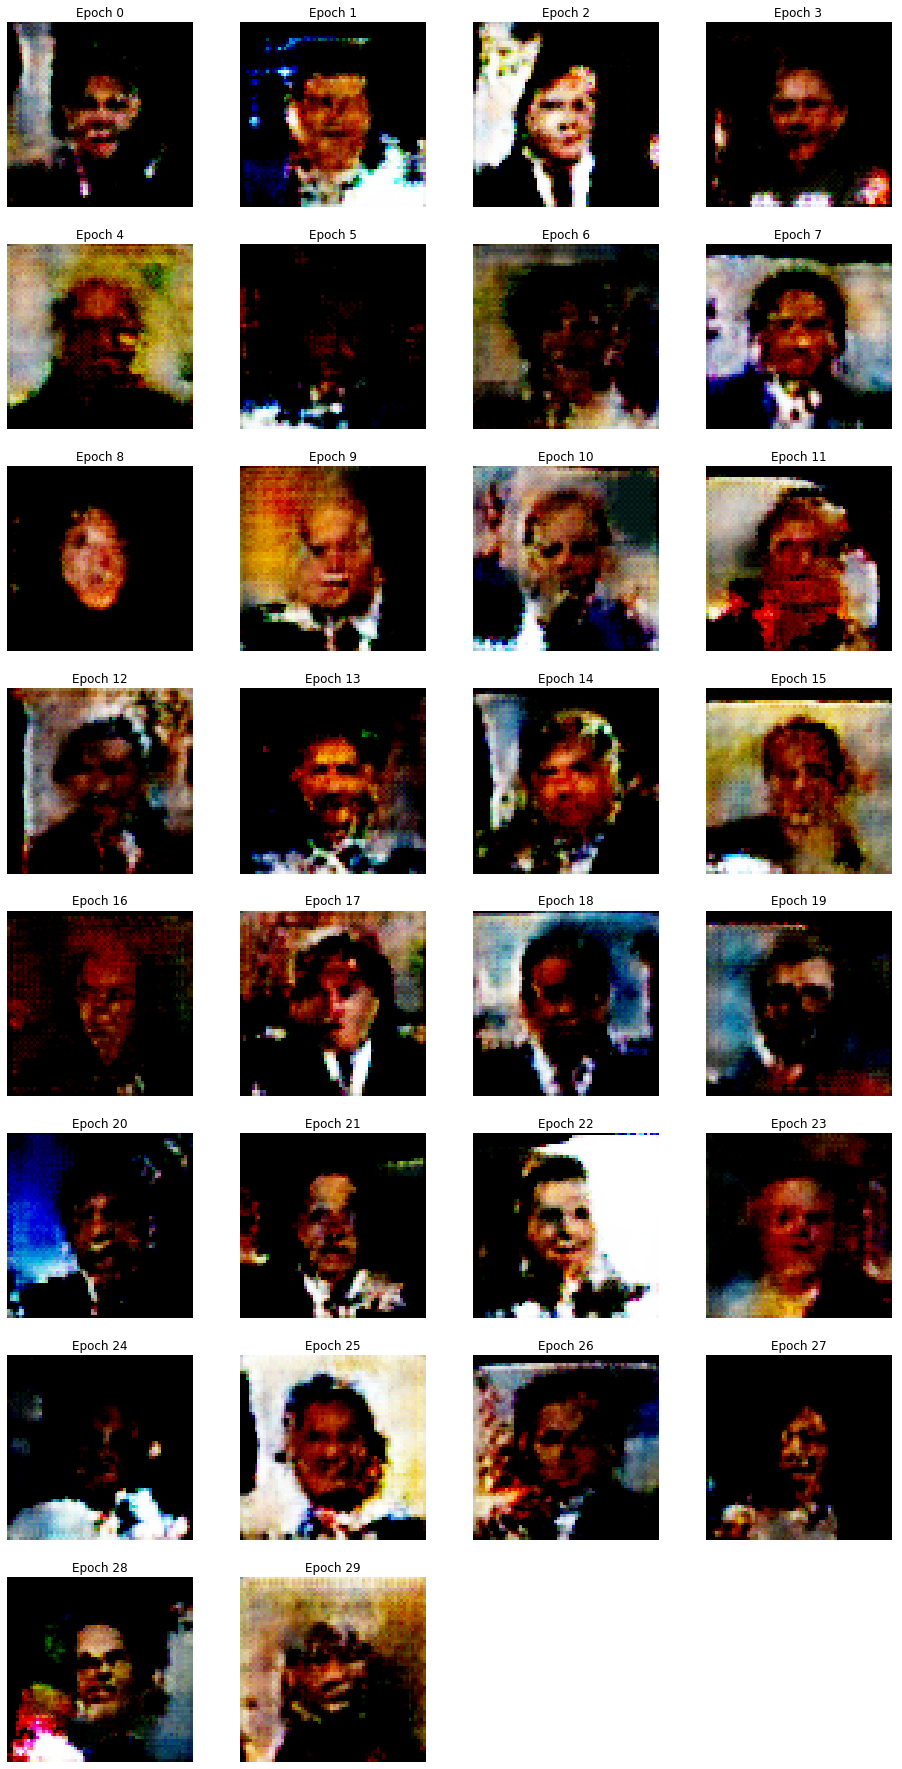

In [0]:
learner.fit(30, lr)
save_gan_learner(learner, models_root + 'wgan-gpTr1a_90it.pth')

epoch,train_loss,valid_loss,gen_loss,disc_loss,time
0,-123.761612,#na#,185.661591,-178.520096,01:06
1,-170.792252,#na#,231.528091,-250.805954,01:06
2,-72.723442,#na#,250.381989,-150.308563,01:06
3,-108.291702,#na#,203.949661,-162.153900,01:06
4,-110.632828,#na#,196.625351,-176.274048,01:07
5,-43.857201,#na#,237.366440,-139.363754,01:06
6,-26.871187,#na#,269.069824,-104.351677,01:07
7,-94.194748,#na#,305.057861,-183.616516,01:07
8,-126.437523,#na#,304.147522,-206.571335,01:07
9,36.674389,#na#,242.361954,24.717667,01:07


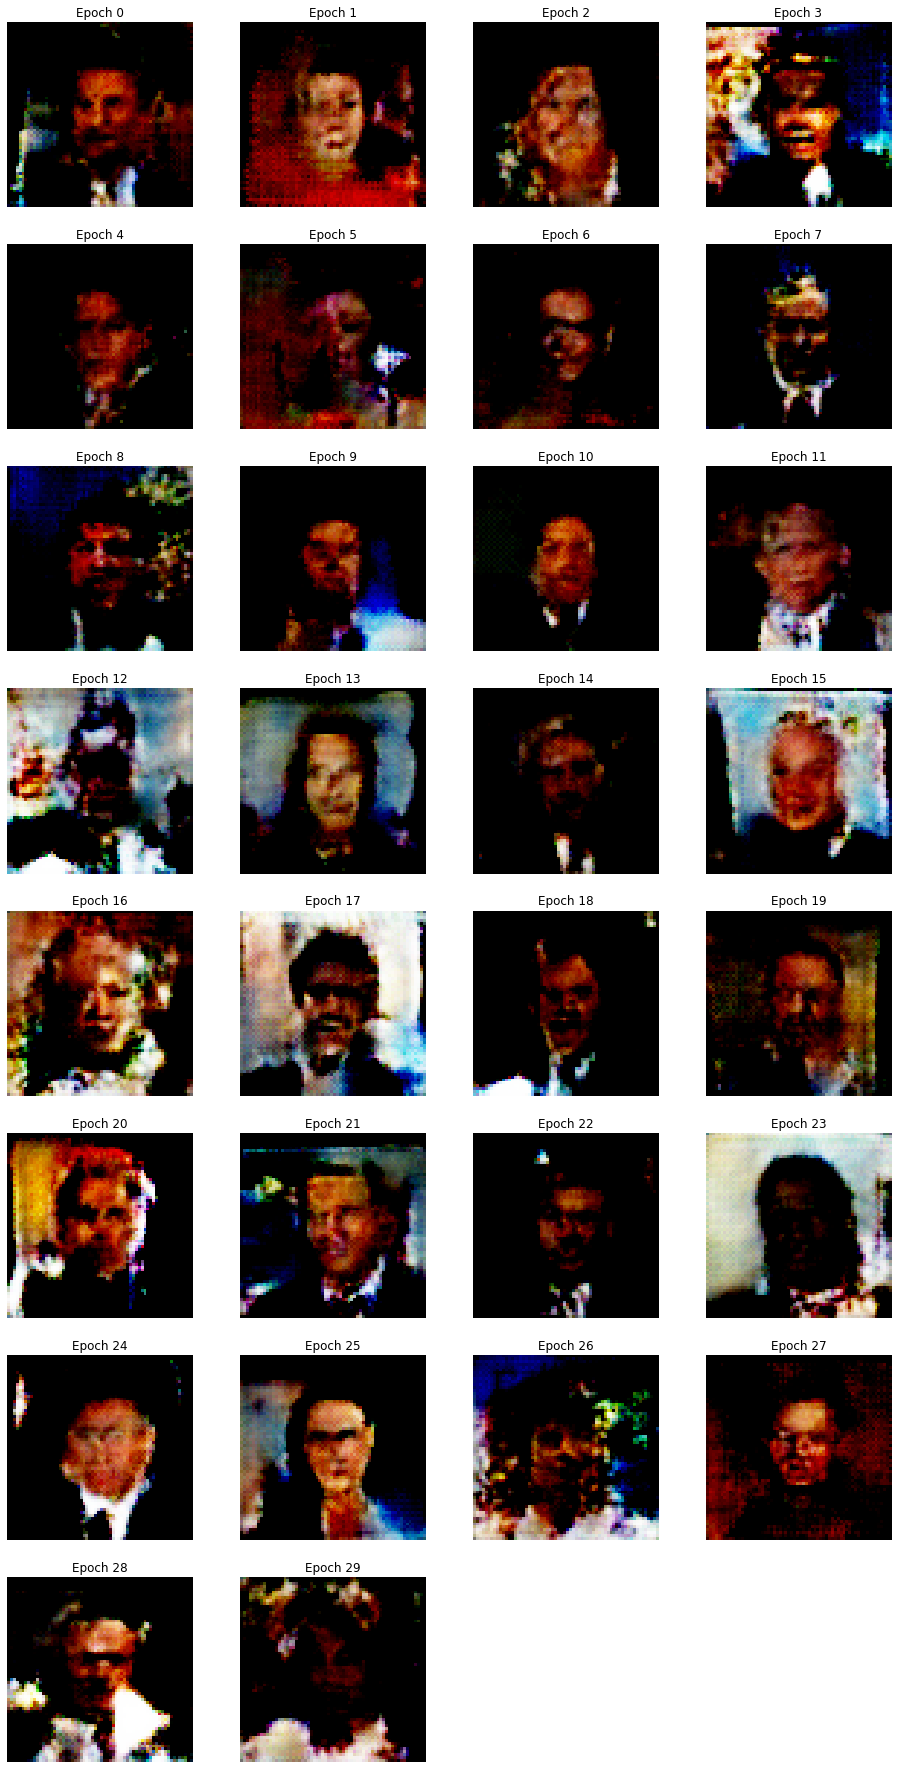

In [0]:
learner.fit(30, lr)
save_gan_learner(learner, models_root + 'wgan-gpTr1a_120it.pth')

### TR 1b: lr=5e-4

In [0]:
lr = 5e-4
critic = basic_critic(img_size, img_n_channels, n_extra_layers=1)
generator = basic_generator(img_size, img_n_channels, n_extra_layers=1)
learner = GANGPLearner.wgan(data, generator, critic, switch_eval=False, opt_func = partial(optim.Adam, betas = (0.,0.99)), wd=0., plambda=plambda)

epoch,train_loss,valid_loss,gen_loss,disc_loss,time
0,-516.544067,#na#,297.617676,-673.863159,01:06
1,-715.104187,#na#,465.005768,-958.094482,01:06
2,-349.501556,#na#,136.561142,-416.391541,01:07
3,-275.857697,#na#,82.464035,-333.981903,01:06
4,-302.108307,#na#,-29.541409,-316.799072,01:06
5,-288.956299,#na#,-98.708099,-299.276306,01:05
6,-300.064484,#na#,-126.836609,-324.690918,01:06
7,-270.915436,#na#,-220.056198,-244.055878,01:06
8,-287.325470,#na#,-208.685135,-307.641815,01:06
9,-303.403442,#na#,-191.333527,-329.940094,01:06


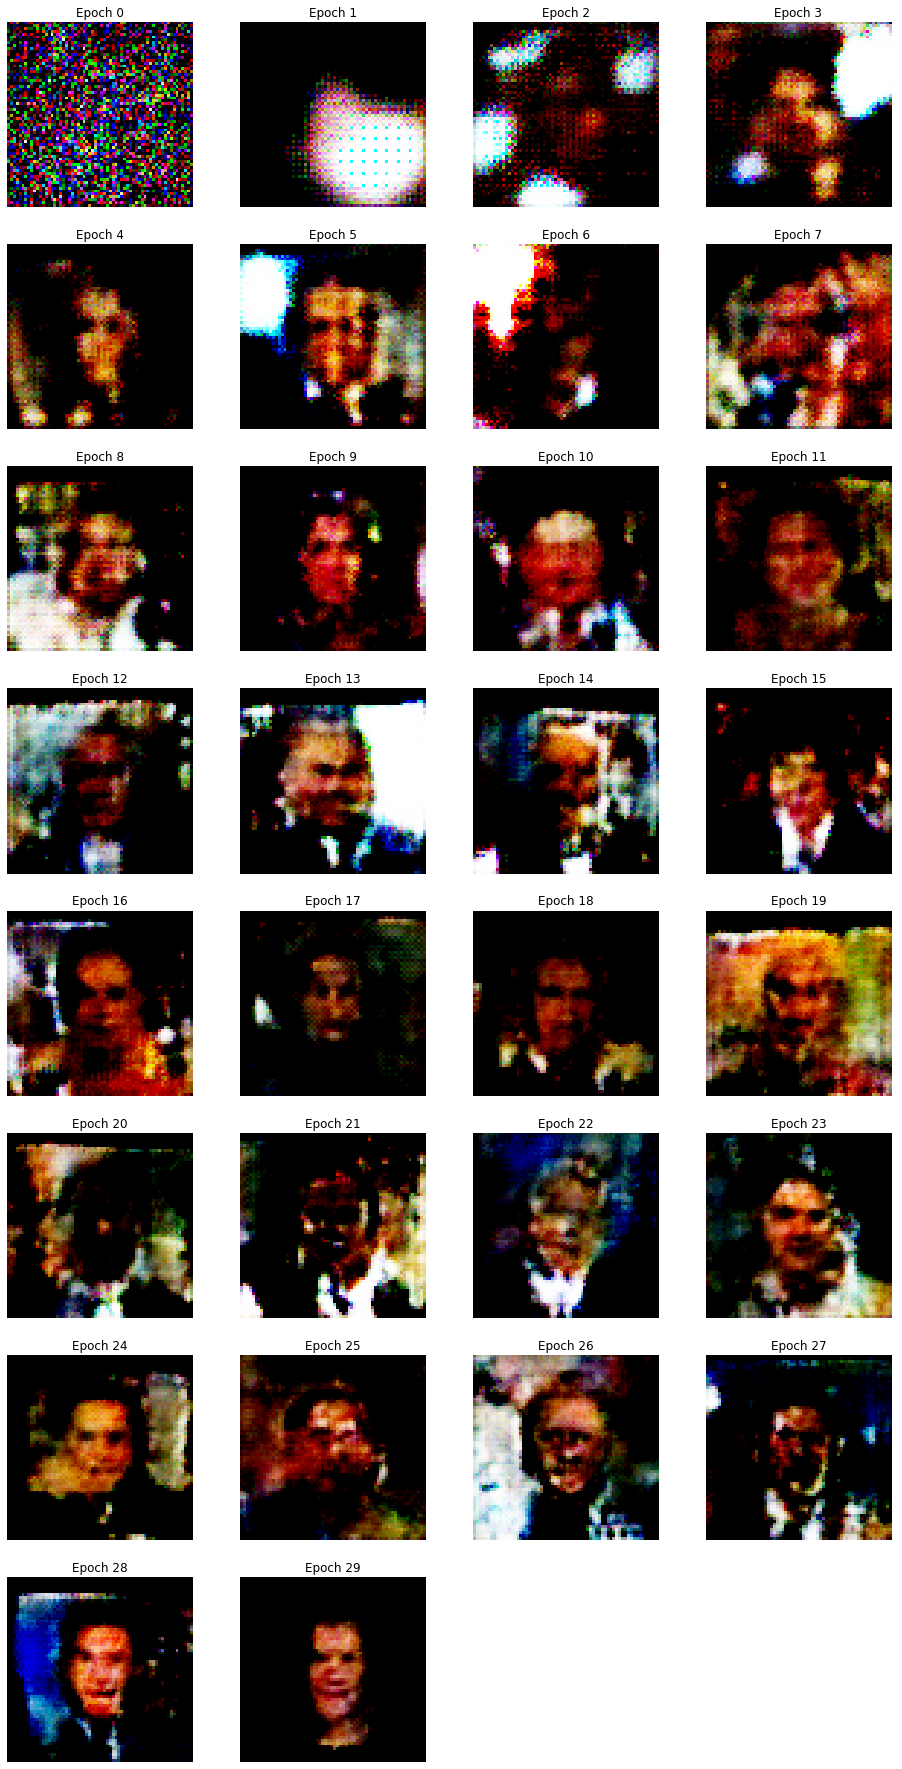

In [0]:
learner.fit(30, lr)
save_gan_learner(learner, models_root + 'wgan-gpTr1b_30it.pth')

epoch,train_loss,valid_loss,gen_loss,disc_loss,time
0,-145.259842,#na#,-50.049347,-159.594223,01:06
1,-194.638306,#na#,4.943342,-252.440903,01:07
2,101.921768,#na#,500.547882,-108.021149,01:06
3,59.483597,#na#,768.375061,-145.116852,01:06
4,22.228937,#na#,885.750488,-175.325912,01:06
5,9.767567,#na#,907.155457,-188.488754,01:05
6,50.064266,#na#,898.529968,-125.725082,01:06
7,-45.725605,#na#,873.663452,-211.397202,01:06
8,0.727828,#na#,900.102966,-186.235687,01:06
9,37.631493,#na#,908.472839,-135.480591,01:06


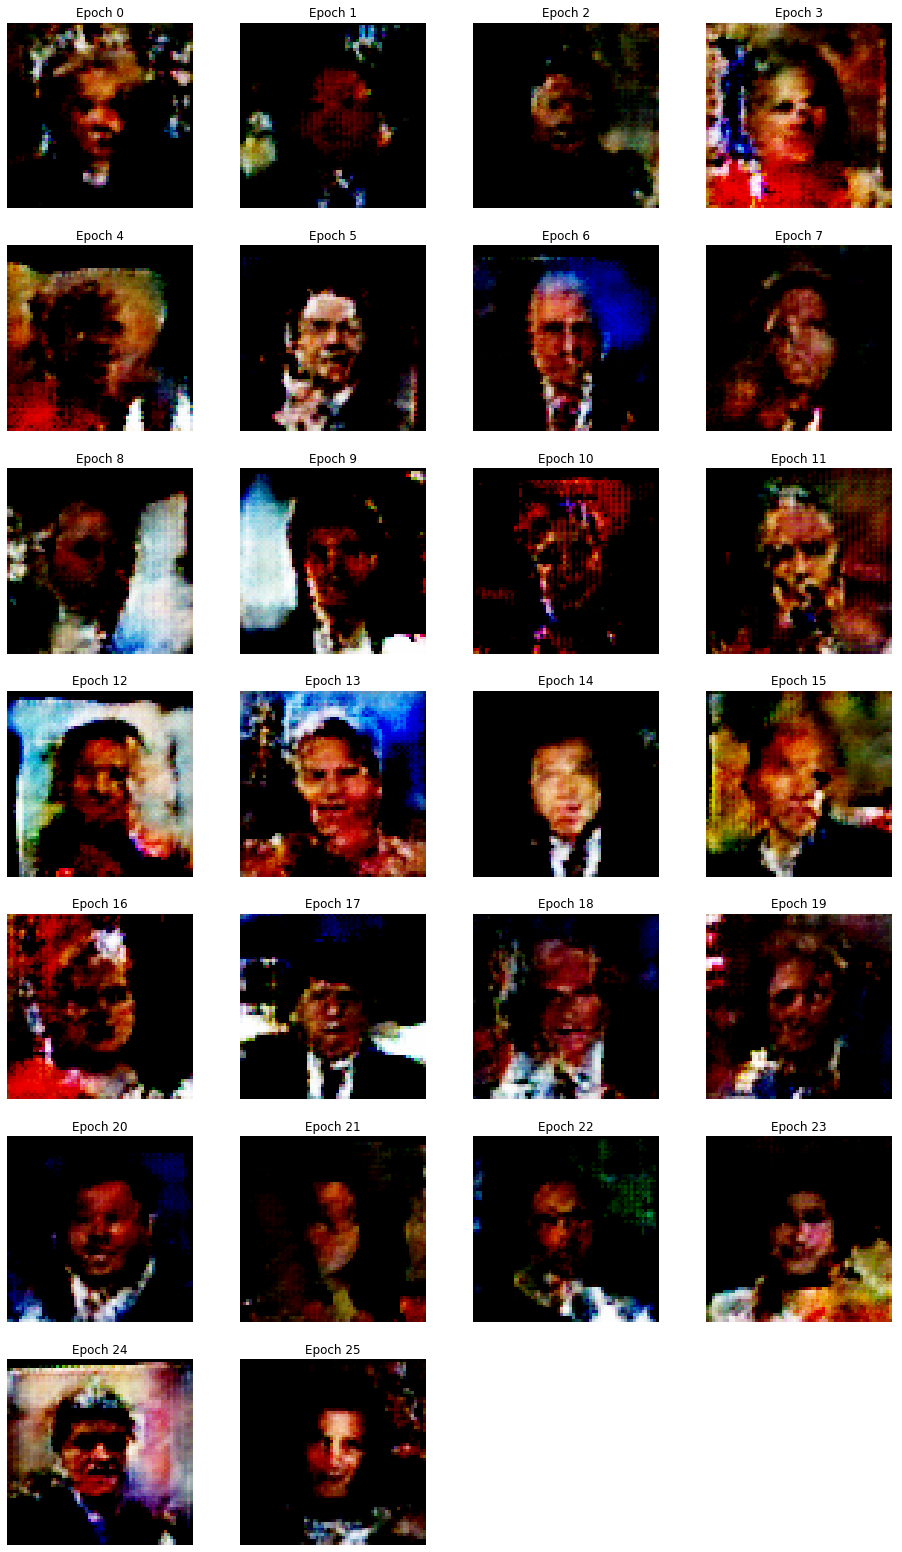

In [0]:
learner.fit(30, lr)
save_gan_learner(learner, models_root + 'wgan-gpTr1b_60it.pth')

epoch,train_loss,valid_loss,gen_loss,disc_loss,time
0,-175.328613,#na#,688.050598,-332.233398,00:37
1,-116.161827,#na#,681.964233,-280.724335,00:37
2,-128.460632,#na#,643.053650,-263.818634,00:37
3,41.326977,#na#,605.858398,-68.661308,00:37
4,44.194763,#na#,580.664124,-49.176769,00:37
5,30.510977,#na#,560.616821,-72.047195,00:36
6,-91.531754,#na#,546.580627,-199.377579,00:37
7,12.423516,#na#,538.173767,-90.009628,00:37
8,67.364220,#na#,554.404480,-43.033398,00:37
9,47.388863,#na#,575.368225,-64.157364,00:37


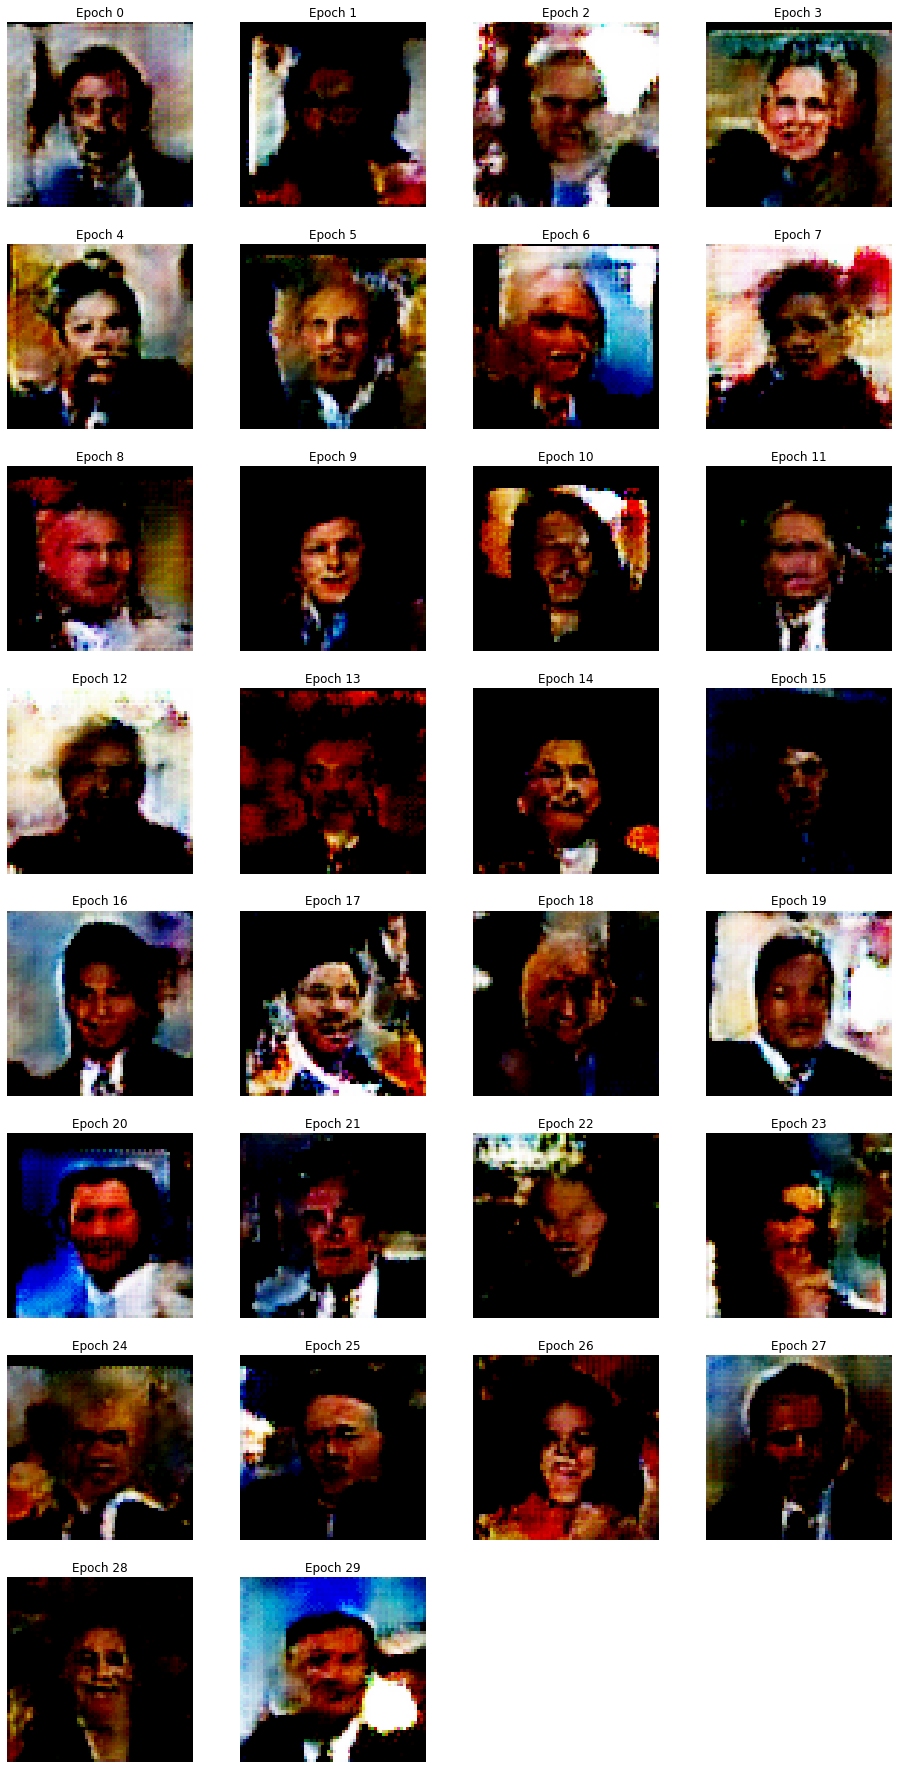

In [0]:
learner.fit(30, lr)
save_gan_learner(learner, models_root + 'wgan-gpTr1b_90it.pth')

epoch,train_loss,valid_loss,gen_loss,disc_loss,time
0,-81.583054,#na#,370.831909,-194.867142,00:37
1,18.710863,#na#,423.940125,-75.289589,00:37
2,-33.222057,#na#,442.733551,-125.774811,00:37
3,-17.646954,#na#,470.589020,-114.430321,00:37
4,-54.022949,#na#,428.157410,-137.994568,00:37
5,-43.839787,#na#,265.784241,-56.090801,00:37
6,-77.986809,#na#,136.965637,-69.087837,00:37
7,-132.052780,#na#,76.058434,-145.415588,00:37
8,-93.500221,#na#,49.065498,-117.746140,00:37
9,-45.364788,#na#,64.324318,-75.616379,00:37


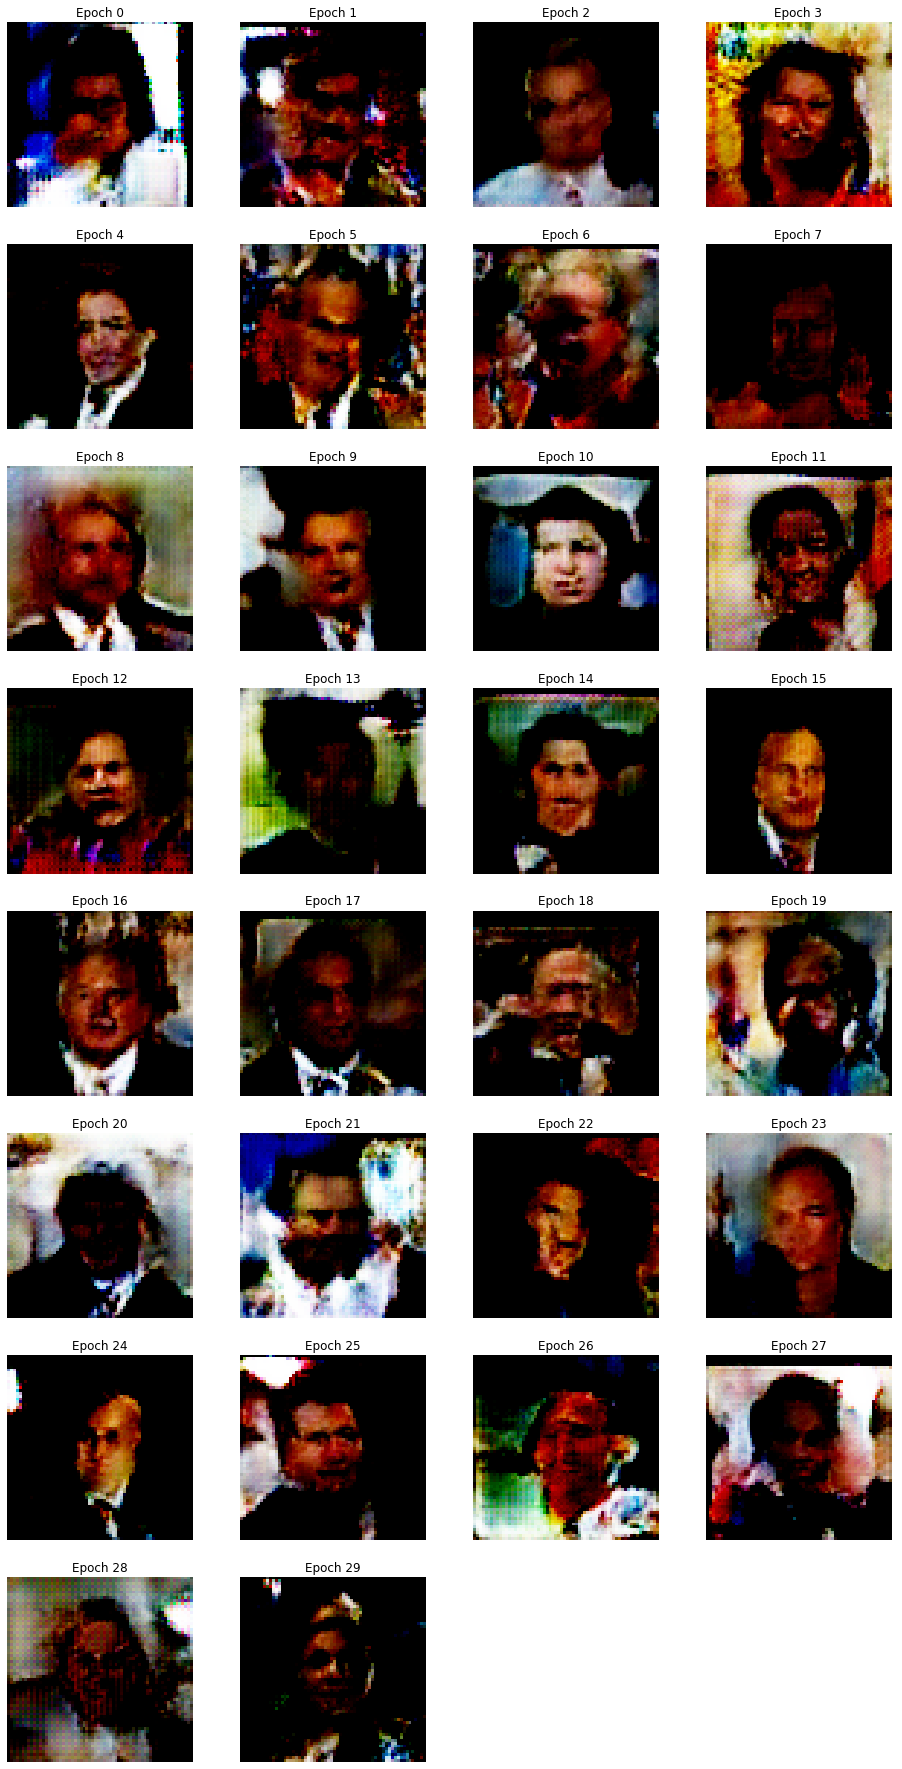

In [0]:
learner.fit(30, lr)
save_gan_learner(learner, models_root + 'wgan-gpTr1b_120it.pth')

# PENDING



* Maybe I'm not dealing well with computation graph in loss calculation
* self.plambda * (grad.norm()^^2 - 1) instead of self.plambda * ((grads.norm() - 1)**2). Some code samples from blogs/articles/... do this, no idea why, as that's not what the paper says.
* Optimize GANGPLoss._gradient_penalty(). Maybe expand_as is not needed.
* Train with more lambda values

